* Implement the Positional Encoding
    1. Perform a random walk on the hypergraph
	    *  WTF does the random walk look like
		* How do I choose the anchor nodes?
		* What is the number of walks I should do?
			* Probably the diameter of the largest component on the graph
    2. append a set onto the data
    3. Develop a masking and train a transformer (look at overriding pytorch geometrics data) on the entire graph (only care about the loss of the masked portion)
    4. Do ablation testing
* Implement the Hypergraph Transformer
    1. 
    

In [1]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.transforms as T

import xgi # for working with hypergraphs

import pandas as pd
import random

c:\Users\Will\Documents\School\CS190J\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Parsing the walmart set:
df = pd.read_csv('data/walmart-hyperedges.tsv', sep='\t')

# # TODO: REMOVE — using a subset of edges for now
subset = True

if subset:
    df = df[:4]

df_nodes = df["nodes"].to_list()
df_nodes = list(map(lambda x: list(map(int, x.split(','))), df_nodes))

df_day_of_week_features = df["dayofweek"].to_list()
df_day_of_week_features = list(map(lambda x: [int(x)], df_day_of_week_features))

df_triptype_labels = df["triptype"].to_list()
df_triptype_labels = list(map(int, df_triptype_labels))

In [10]:
# Create a Hypergraph from Walmart Data, using xgi
H = xgi.Hypergraph()
# print("num nodes:", num_nodes)
# H.add_nodes_from(range(num_nodes))
use_toy = True
if use_toy:
    he_nodes = [[1,3],
[1,2,8],
[1,2,4,5],
[2,5,6],
[3,6,7],
[7,9]]
    for he in he_nodes:
        H.add_edge(he)
else:
    for he_nodes in df_nodes:
        H.add_edge(he_nodes)

    #remove node 0 if it exists
    if 0 in H.nodes:
        H.remove_node(0)

array([[1, 1, 1, 0, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 1]])

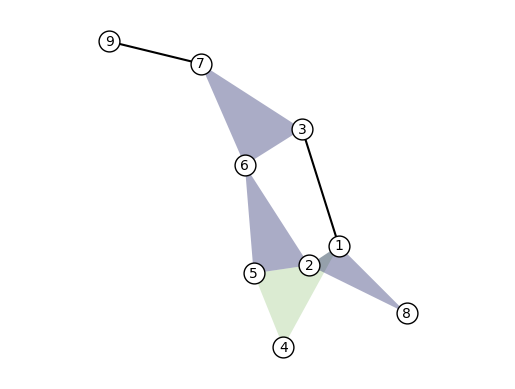

In [15]:
if use_toy:
    xgi.draw(H,node_labels=True, node_size=15)  # visualize the hypergraph
else:
    xgi.draw(H)  # visualize the hypergraph
e = xgi.convert.to_incidence_matrix(H)  # get incidence matrix
e.toarray()  # convert to dense array

In [ ]:
C = e.T @ e # node-node adjacency matrix
# C_hat is defined by just the diagonal of C
C_hat = C * torch.eye(C.shape[0])
# C_hat.toarray()
adj_mat = e @ e.T
transition_mat =  e @ C_hat @ e.T - adj_mat
print("Transition matrix:\n", transition_mat.toarray())

Transition matrix:
 [[6. 1. 2. 5. 3. 3. 0. 0. 0.]
 [1. 3. 0. 0. 0. 0. 2. 2. 0.]
 [2. 0. 2. 2. 0. 0. 0. 0. 0.]
 [5. 0. 2. 7. 3. 5. 2. 0. 0.]
 [3. 0. 0. 3. 3. 3. 0. 0. 0.]
 [3. 0. 0. 5. 3. 5. 2. 0. 0.]
 [0. 2. 0. 2. 0. 2. 4. 2. 0.]
 [0. 2. 0. 0. 0. 0. 2. 3. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]]


In [19]:
sum(transition_mat[0].toarray())

np.float64(20.0)

In [96]:
for i in range(4):
    print(sum(transition_mat[i].toarray()))

210.0
1846.0
2026.0
3552.0


In [ ]:
random.seed(42)
# multiply by a one hot array where only the first position is 1
anchor_node = torch.zeros((transition_mat.shape[0], 1))
for t in range(4):
    anchor_node[random.choice(range(transition_mat.shape[0]))] = 1

random_walks = anchor_node
for _ in range(10):
    random_walks = transition_mat @ random_walks

random_walks

array([[1.49693913e+38],
       [1.64215302e+40],
       [1.04177624e+40],
       ...,
       [4.81896369e+38],
       [2.38953918e+37],
       [4.54457050e+38]])

In [ ]:


# ------------------------------------------------------------
# Base Positional Encoding Interface
# ------------------------------------------------------------
class PositionalEncoding(nn.Module):
    def forward(self, x, hypergraph):
        raise NotImplementedError("Implement in subclass")

# ------------------------------------------------------------
# Random Walk Positional Encoding
# ------------------------------------------------------------
class RandomWalkPE(PositionalEncoding):
    def __init__(self, pe_dim, num_walks=10, walk_length=5):
        super().__init__()
        self.pe_dim = pe_dim
        self.num_walks = num_walks
        self.walk_length = walk_length
        self.embed = nn.Embedding(10000, pe_dim)  # dynamically sized in practice

    def generate_random_walks(self, hypergraph):
        H = hypergraph.incidence_matrix
        num_nodes = H.size(0)
        node_neighbors = (H @ H.T > 0).float()  # simple node-node adjacency

        walks = []
        for start_node in range(num_nodes):
            for _ in range(self.num_walks):
                walk = [start_node]
                current = start_node
                for _ in range(self.walk_length - 1):
                    probs = node_neighbors[current]
                    probs[current] = 0  # no self-loops
                    if probs.sum() == 0:
                        break
                    next_node = torch.multinomial(probs, 1).item()
                    walk.append(next_node)
                    current = next_node
                walks.append(walk)
        return walks

    def forward(self, x, hypergraph):
        # Generate random walks (could be cached for efficiency)
        walks = self.generate_random_walks(hypergraph)

        # Map node occurrences to embeddings
        node_walks = [[] for _ in range(hypergraph.num_nodes)]
        for walk in walks:
            for node in walk:
                node_walks[node].append(torch.tensor(walk))

        pe = torch.zeros((hypergraph.num_nodes, self.pe_dim), device=x.device)
        for i, walk_list in enumerate(node_walks):
            if len(walk_list) == 0:
                continue
            emb = torch.stack([
                self.embed(walk.to(x.device)).mean(dim=0) for walk in walk_list
            ])
            pe[i] = emb.mean(dim=0)
        return torch.cat([x, pe], dim=-1)

# ------------------------------------------------------------
# Hypergraph Transformer Layer
# ------------------------------------------------------------
class HypergraphTransformerLayer(nn.Module):
    def __init__(self, in_dim, out_dim, num_heads=4, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.attn = nn.MultiheadAttention(out_dim, num_heads, dropout=dropout)
        self.linear_in = nn.Linear(in_dim, out_dim)
        self.ff = nn.Sequential(
            nn.Linear(out_dim, out_dim * 4),
            nn.ReLU(),
            nn.Linear(out_dim * 4, out_dim)
        )
        self.norm1 = nn.LayerNorm(out_dim)
        self.norm2 = nn.LayerNorm(out_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hypergraph):
        H = hypergraph.incidence_matrix
        node2edge = H.T @ x  # aggregate nodes to hyperedges
        edge2node = H @ node2edge  # propagate back

        # project edge features to attention embedding
        q = k = v = self.linear_in(edge2node)
        attn_out, _ = self.attn(q.unsqueeze(1), k.unsqueeze(1), v.unsqueeze(1))
        attn_out = attn_out.squeeze(1)

        # project node features to the same embedding dim so residual addition matches
        node_proj = self.linear_in(x)
        x = self.norm1(node_proj + self.dropout(attn_out))

        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout(ff_out))
        return x

# ------------------------------------------------------------
# Full Hypergraph Transformer Model
# ------------------------------------------------------------
class HGNNTransformer(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, pe_module, num_layers=2):
        super().__init__()
        self.pe_module = pe_module
        self.layers = nn.ModuleList([
            HypergraphTransformerLayer(
                in_dim + getattr(pe_module, "pe_dim", 0) if i == 0 else hidden_dim,
                hidden_dim
            )
            for i in range(num_layers)
        ])
        self.output = nn.Linear(hidden_dim, out_dim)

    def forward(self, x, hypergraph):
        x = self.pe_module(x, hypergraph)
        for layer in self.layers:
            x = layer(x, hypergraph)
        return self.output(x)

# ------------------------------------------------------------
# Dummy Hypergraph Data
# ------------------------------------------------------------
class DummyHypergraph:
    def __init__(self, H):
        self.incidence_matrix = H
        self.num_nodes = H.size(0)
        self.num_hyperedges = H.size(1)

# ------------------------------------------------------------
# Example Usage
# ------------------------------------------------------------
if __name__ == "__main__":
    num_nodes = 10
    num_hyperedges = 4
    in_dim = 8
    pe_dim = 6
    hidden_dim = 32
    out_dim = 5

    x = torch.randn(num_nodes, in_dim)
    H = torch.randint(0, 2, (num_nodes, num_hyperedges)).float()
    hypergraph = DummyHypergraph(H)

    pe = RandomWalkPE(pe_dim)
    model = HGNNTransformer(in_dim, hidden_dim, out_dim, pe, num_layers=2)
    out = model(x, hypergraph)
    print("Output shape:", out.shape)


Output shape: torch.Size([10, 5])
